In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import keras
from keras.layers import Activation, Dense, Input, LSTM, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Sequential
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

In [27]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)
savefig = False

In [12]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [13]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]
    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser-rnn'
EXPERIMENT_ID = get_id_for_experiment_with_name(experiment_name)

In [14]:
print('Running YASS version: {}\nExperiment: {}'
      .format(yass_util.get_version(), experiment_name))

Running YASS version: 01bd23e min shift param is now passed through collided params
Experiment: denoiser-rnn


In [15]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Load training set

In [16]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() 
experiment = client.get_experiment_by_name('denoiser-training-set')
training_set_runs = client.list_run_infos(experiment.experiment_id)

In [17]:
selected = [run for run in training_set_runs if run.run_uuid == 'e0832204e3764b38bc1781bf0e884c90'][0]

In [18]:
path_to_training_set = Path(selected.artifact_uri, 'dataset.npz')

In [19]:
dataset = np.load(path_to_training_set)

In [20]:
x_train_noisy = dataset['x_train_noisy']
x_train_clean = dataset['x_train_clean']
x_test_noisy = dataset['x_test_noisy']
x_test_clean = dataset['x_test_clean']

In [25]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

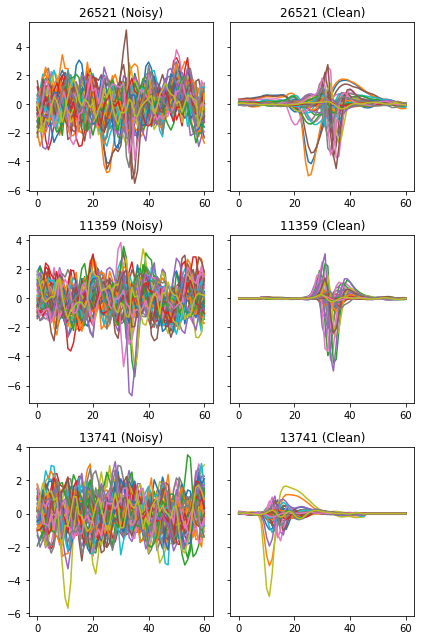

In [26]:
plot.grid_from_array([x_test_noisy,
                      x_test_clean],
                     axis=0,
                     group_names=('Noisy', 'Clean'),
                     elements=selected[:3],
                     auto_figsize=3,
                     sharey='row')

In [28]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

In [30]:
selected_channels = ch_idx[0]

In [32]:
_, wf_length, _ = x_train_noisy.shape

In [35]:
middle = int((wf_length - 1)/2)

In [73]:
x_train = x_train_noisy[:, :, selected_channels]
x_test = x_test_noisy[:, :, selected_channels]

y_train = x_train_clean[:, middle, selected_channels]
y_test = x_test_clean[:, middle, selected_channels]

In [74]:
n_spikes, waveform_length, n_neighbors = x_train.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 512
kernel_size = 3
latent_dim = 40

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 32, 32, 32]
n_layers = len(layer_filters)

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)

y = Dense(7, activation='linear')(x)

denoiser = Model(inputs, y, name='denoiser')
denoiser.summary()

denoiser.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 7, 1)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 7, 32)         320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 7, 32)         9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 7, 32)         9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 61, 7, 32)         9248      
_________________________________________________________________
flatten_6 (Flatten)          (None, 13664)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 95655     
Total para

In [75]:
# Training parameters
epochs = 10
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)]

history = denoiser.fit(x_train[:, :, :, np.newaxis],
                       y_train,
                       validation_data=(x_test[:, :, :, np.newaxis],
                                        y_test),
                       epochs=epochs,
                       callbacks=callbacks,
                       batch_size=batch_size)

Train on 73920 samples, validate on 31680 samples
Epoch 1/10
73920/73920 [==============================] - 9s 127us/step - loss: 0.0936 - val_loss: 0.0714
Epoch 2/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0693 - val_loss: 0.0684
Epoch 3/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0642 - val_loss: 0.0617
Epoch 4/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0613 - val_loss: 0.0584
Epoch 5/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0589 - val_loss: 0.0582
Epoch 6/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0571 - val_loss: 0.0573
Epoch 7/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0554 - val_loss: 0.0547
Epoch 8/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0543 - val_loss: 0.0557
Epoch 9/10
73920/73920 [==============================] - 9s 119us/step - loss: 0.0529 - val_loss: 0.0

## Denoising recordings

In [127]:
exp = RecordingExplorer(path_to_standarized)

In [149]:
patch_size = 61
n_patches = 200
offset = 150000

In [150]:
idxs = [(n, n + patch_size) for n in range(n_patches)]

In [151]:
patches = np.empty((n_patches, patch_size, 7, 1))

for i, (from_, to_) in enumerate(idxs):
    patches[i, :, :, 0] = exp.reader[from_:to_, selected_channels]

In [152]:
patches_denoised = np.squeeze(denoiser.predict(patches))

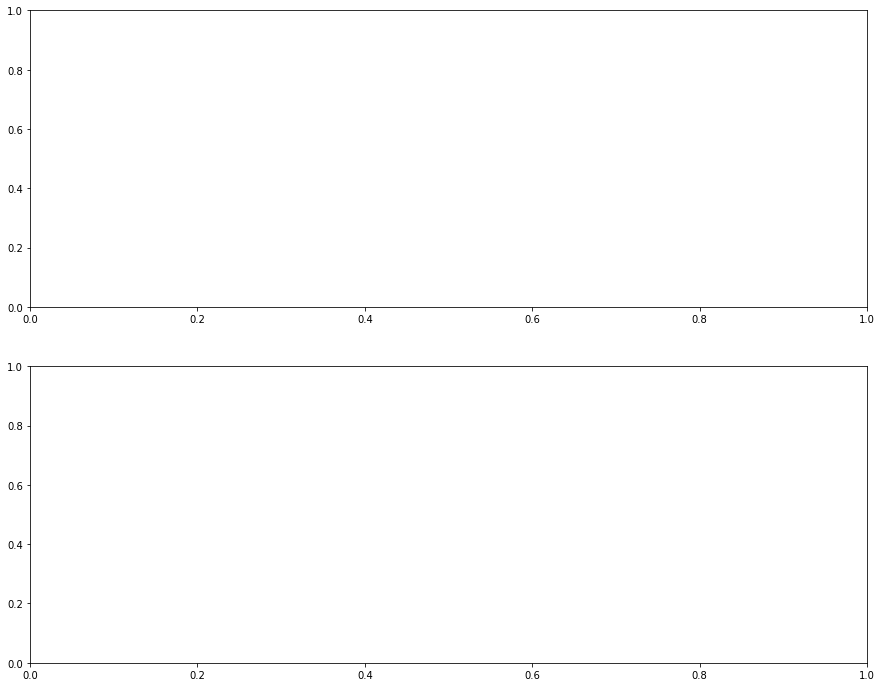

In [153]:
plt.rcParams['figure.figsize'] = (15, 12)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

In [154]:
_ = ax1.plot(patches_denoised)


start = idxs[0][0] + 30
end = idxs[-1][1] - 30

_ = ax2.plot(exp.reader[start:end, selected_channels])

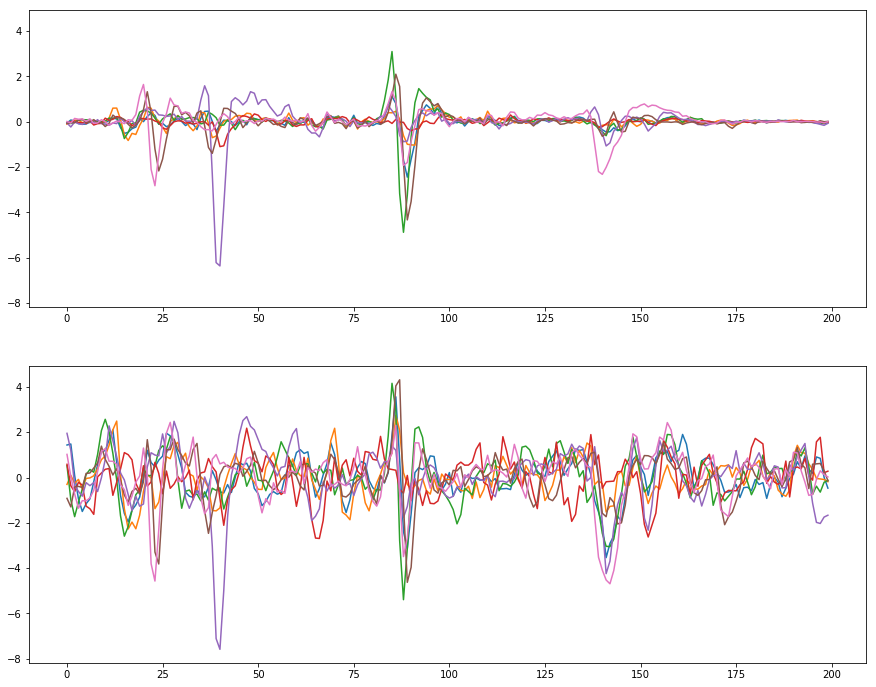

In [155]:
fig